<a href="https://colab.research.google.com/github/saturnMars/FM_2025/blob/main/Lab1_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from os import path
import pandas as pd
import tarfile

# Getting the labelled datasets for:
- ***binary* classification**:
    1. **Truthfulness** (True/false claims)
        - *[The Geometry of Truth: Emergent Linear Structure in Large Language Model Representations of True/False Datasets](https://github.com/saprmarks/geometry-of-truth/tree/main)*
    2. **Subjectivity** (subjective/objetive sentences)
        - [CLEF 2025, Task 1 - Subjectivity](https://checkthat.gitlab.io/clef2025/task1/)
- ***multiclass* classification**:
    3. **Tense** (past/present/future)
        - [EnglishTense: A large scale English texts dataset categorized into three categories: Past, Present, Future tenses.](https://data.mendeley.com/datasets/jnb2xp9m4r/2)
    4. **Language** (utterances from multiple languages)
        - [MASSIVE: A 1M-Example Multilingual Natural Language Understanding Dataset with 51 Typologically-Diverse Languages](https://github.com/alexa/massive)



In [2]:
!wget https://data.mendeley.com/public-files/datasets/jnb2xp9m4r/files/8148432a-a69a-473f-beb6-835d2a176f30/file_downloaded

--2025-09-26 12:59:40--  https://data.mendeley.com/public-files/datasets/jnb2xp9m4r/files/8148432a-a69a-473f-beb6-835d2a176f30/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
162.159.130.86, 162.159.133.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.130.86|:443... connected.
HTTP request sent, awaiting response... HTTP request sent, awaiting response... 302 Found
Location: https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/28304dc7-a47c-4d83-bdcc-2edc535236d8 [following]
--2025-09-26 12:59:41--  https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/28304dc7-a47c-4d83-bdcc-2edc535236d8
Resolving prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com)... 302 Found
Location: https://prod-dcd-datasets-public-files

In [3]:
# (1) TRUTHFULNESS (The Geometry of Truth; TRUE|FALSE)
truthfulness_df = pd.read_csv("https://raw.githubusercontent.com/saprmarks/geometry-of-truth/refs/heads/main/datasets/counterfact_true_false.csv")
truthfulness_df = truthfulness_df[['statement', 'label']].rename(columns = {'statement':'doc'})

# (2) SUBJECTIVITY (CLEF2025; SUB|OBJ)
subjectivity_df = pd.concat([
    pd.read_csv("https://gitlab.com/checkthat_lab/clef2025-checkthat-lab/-/raw/main/task1/data/english/train_en.tsv", sep= '\t'),
    pd.read_csv("https://gitlab.com/checkthat_lab/clef2025-checkthat-lab/-/raw/main/task1/data/english/dev_en.tsv", sep= '\t'),
    pd.read_csv("https://gitlab.com/checkthat_lab/clef2025-checkthat-lab/-/raw/main/task1/data/english/dev_test_en.tsv", sep= '\t'),
    pd.read_csv("https://gitlab.com/checkthat_lab/clef2025-checkthat-lab/-/raw/main/task1/data/english/test_en_labeled.tsv", sep= '\t'),
])
subjectivity_df = subjectivity_df[['sentence', 'label']].rename(columns = {'sentence':'doc'})

# (3) TENSE (EnglishTense; past|present|future)
tense_df = pd.read_excel("https://prod-dcd-datasets-public-files-eu-west-1.s3.eu-west-1.amazonaws.com/28304dc7-a47c-4d83-bdcc-2edc535236d8").rename(columns = {'Sentence':'doc', 'Labels':'label'})
tense_df['label'] = tense_df['label'].str.upper() # Turnaround to fix a bug in the dataset labels

# (4) LANGUAGE (MASSIVE; EN/IT/DE/ES)
!wget https://amazon-massive-nlu-dataset.s3.amazonaws.com/amazon-massive-dataset-1.1.tar.gz
dfs = []
with tarfile.open("amazon-massive-dataset-1.1.tar.gz", "r:gz") as tar:
    for lang in ['en-US', 'it-IT', 'de-DE', 'es-ES']:
      dfs.append(pd.read_json(tar.extractfile(path.join('1.1','data', f'{lang}.jsonl')), lines = True))
language_df = pd.concat(dfs)[['utt', 'locale']].rename(columns = {'utt':'doc', 'locale': 'label'})

--2025-09-26 12:59:44--  https://amazon-massive-nlu-dataset.s3.amazonaws.com/amazon-massive-dataset-1.1.tar.gz
Resolving amazon-massive-nlu-dataset.s3.amazonaws.com (amazon-massive-nlu-dataset.s3.amazonaws.com)... 52.217.163.233, 16.15.187.93, 54.231.130.49, ...
Connecting to amazon-massive-nlu-dataset.s3.amazonaws.com (amazon-massive-nlu-dataset.s3.amazonaws.com)|52.217.163.233|:443... 52.217.163.233, 16.15.187.93, 54.231.130.49, ...
Connecting to amazon-massive-nlu-dataset.s3.amazonaws.com (amazon-massive-nlu-dataset.s3.amazonaws.com)|52.217.163.233|:443... connected.
connected.
HTTP request sent, awaiting response... HTTP request sent, awaiting response... 200 OK
Length: 40251390 (38M) [application/x-gzip]
Saving to: ‘amazon-massive-dataset-1.1.tar.gz.7’

          amazon-ma   0%[                    ]       0  --.-KB/s               200 OK
Length: 40251390 (38M) [application/x-gzip]
Saving to: ‘amazon-massive-dataset-1.1.tar.gz.7’

amazon-massive-data 100%[===================>]  38,

# Data exploration

In [4]:
# TRUTHFULNESS dataset
print('-' * 30, 'TRUTHFULNESS', '-' * 30)
print(f"CLASSES ({truthfulness_df['label'].nunique()}):", '|'.join(truthfulness_df['label'].map(str).unique()), '\n')
print(truthfulness_df)

# SUBJECTIVITY dataset
print('-' * 30, 'SUBJECTIVITY', '-' * 30)
print(f"CLASSES ({subjectivity_df['label'].nunique()}):", '|'.join(subjectivity_df['label'].unique()), '\n')
print(subjectivity_df)

# TENSE dataset
print('-' * 30, 'TENSE', '-' * 30)
print(f"CLASSES ({tense_df['label'].nunique()}):", '|'.join(tense_df['label'].unique()), '\n')
print(tense_df)

# LANGUAGE dataset
print('-' * 30, 'LANGUAGE', '-' * 30)
print(f"CLASSES ({language_df['label'].nunique()}):", '|'.join(language_df['label'].unique()), '\n')
print(language_df)

------------------------------ TRUTHFULNESS ------------------------------
CLASSES (2): 1|0 

                                                     doc  label
0      The mother tongue of Danielle Darrieux is French.      1
1      The mother tongue of Danielle Darrieux is Engl...      0
2      The official religion of Edwin of Northumbria ...      1
3      The official religion of Edwin of Northumbria ...      0
4      The mother tongue of Thomas Joannes Stieltjes ...      1
...                                                  ...    ...
31959          Jerusalem of Gold was written in Finnish.      0
31960  The language used by Jean-Pierre Dionnet is Fr...      1
31961  The language used by Jean-Pierre Dionnet is Sp...      0
31962                             Subair works as actor.      1
31963                          Subair works as composer.      0

[31964 rows x 2 columns]
------------------------------ SUBJECTIVITY ------------------------------
CLASSES (2): SUBJ|OBJ 

             

## Create *Dataset*, *DataLoader* (PyTorch), and *DataModule* (PyTorch Lightining) for training
1. PyTorch: [Dataset/DataLoader](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html)
2. PyTorch Lightining [DataModule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html)


In [5]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch

In [6]:
class MyDataset(Dataset):
    def __init__(self, df:pd.DataFrame):

        # Create our inputs (X)
        self.inputs = df['doc'].values

        # Convert the textual labels into numbers (CLASS A --> 0, CLASS B --> 1, ...)
        self.class_mapping = {label: i for i, label in enumerate(df['label'].unique())}

        # Create our outputs (y)
        self.targets = df['label'].map(self.class_mapping).values

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


In [7]:
!pip install lightning

In [8]:
from lightning import LightningDataModule

/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
class MyDataModule(LightningDataModule):
    def __init__(self, data: Dataset, batch_size: int = 32, val_size:float = 0.1, test_size:float = 0.1):
        super().__init__()

        # Initialize the variables
        self.data = data
        self.batch_size = batch_size

        self.train_size = 1 - val_size - test_size
        self.val_size = val_size
        self.test_size = test_size

        # Set the seed for reproducibility
        self.random_seed = 101

    def setup(self, stage:str):

        # Create the splits
        train_set, val_set, test_set = random_split(
            dataset = self.data,
            generator = torch.Generator().manual_seed(self.random_seed),
            lengths = [self.train_size, self.val_size, self.test_size])

        self.train_set = train_set
        self.val_set = val_set
        self.test_set = test_set

        print('\nINPUTS:', len(self.data), '--> TRAIN:', round(((len(self.train_set) / len(self.data)) * 100), 1), '%',
              '|| VALIDATION:', round(((len(self.val_set) / len(self.data)) * 100), 1), '%',
              '|| TEST:', round(((len(self.test_set) / len(self.data)) * 100), 1), '%', '\n')

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size = self.batch_size, shuffle = True)

    def val_dataloader(self):
        return DataLoader(self.val_set, batch_size = self.batch_size, shuffle = False)

    def test_dataloader(self):
        return DataLoader(self.test_set, batch_size = self.batch_size, shuffle = False)

# Explore the dataloader

In [10]:
# Initialize the dataset and the dataloders
dataset = MyDataset(tense_df)
dataloaders = MyDataModule(dataset, batch_size = 32, val_size = 0.1, test_size = 0.1)

# Create the splits and explore the train loader
dataloaders.setup('')
train_set = dataloaders.train_dataloader()

# Get the first batch
x, y = list(train_set)[0]
label_mapping = {v: k for k, v in dataset.class_mapping.items()}
for x_item, y_item in zip(x, y):
    print("DOC:", x_item, "--> CLASS:", y_item.item(), f'({label_mapping[y_item.item()]})')


INPUTS: 13316 --> TRAIN: 80.0 % || VALIDATION: 10.0 % || TEST: 10.0 % 

DOC: she swerved to avoid a pedestrian and hit a parked car --> CLASS: 2 (PAST)
DOC: they received a grant to fund their research project --> CLASS: 2 (PAST)
DOC: they attended a live concert and sang along to their favorite songs --> CLASS: 2 (PAST)
DOC: they practiced moderation and balance in their eating habits --> CLASS: 2 (PAST)
DOC: we had synchronized our calendars before scheduling the meeting --> CLASS: 2 (PAST)
DOC: he bought a used car last month --> CLASS: 2 (PAST)
DOC: tourists marveled at the pyramids towering height and monumental scale --> CLASS: 2 (PAST)
DOC: noise pollution will be keeping residents awake at night. --> CLASS: 0 (FUTURE)
DOC: fashion trends will draw inspiration from a multitude of cultural sources --> CLASS: 0 (FUTURE)
DOC: bangladeshi food will be a gastronomic adventure --> CLASS: 0 (FUTURE)
DOC: religious beliefs and cultural practices regarding family size and reproduction w

# Create our custom model for classification: a frozen LLM with a Multi Layer Perceptron (MLP)

In [11]:
import torch.nn as nn
from transformers import AutoModel, AutoTokenizer

In [12]:
class Network(nn.Module):
    def __init__(self, llm_name:str, num_classes: int):
        super().__init__()
        self.num_classes = num_classes

        # Set the latent dimension
        self.latent_dim = 512

        # Set the probability for the dropout layer
        self.drop_p = 0.3

        # Load the foundation language model
        self.tokenizer = AutoTokenizer.from_pretrained(llm_name)
        self.llm = AutoModel.from_pretrained(llm_name)

        # Define the token for padding and its direction
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.padding_side = 'left'

        # Create our custom layers
        self.decoder_layer = nn.Sequential(

            # Layer 0
            nn.Linear(self.llm.config.hidden_size, self.latent_dim),
            nn.ReLU(),
            nn.LayerNorm(self.latent_dim),
            nn.Dropout(self.drop_p),

            # Layer 1
            nn.Linear(self.latent_dim, self.latent_dim),
            nn.ReLU(),
            nn.LayerNorm(self.latent_dim)
        )

        # Create our output layer
        self.output_layer = nn.Sequential(
            nn.LayerNorm(self.latent_dim),
            nn.Linear(self.latent_dim, self.num_classes),
            nn.Softmax(dim = 1) # Get probability distribution over the classes [batch_size, num_classes]
        )

    def forward(self, x):

        # Tokenize the textual document (x)
        input_ids = self.tokenizer(x, padding = True, return_tensors = 'pt').to(self.llm.device)

        # Process the tokenized document using the frozen LLM
        llm_output = self.llm(**input_ids)

        # Get the embeddings from the median hidden layer [batch_size, num_layers, hidden_dim]
        median_layer = self.llm.config.num_hidden_layers // 2
        embeddings = llm_output['last_hidden_state'][:, median_layer, :]

        # Learn the latent fetures from the LLM embeddings
        out = self.decoder_layer(embeddings)

        # Output layer with the SoftMax
        out = self.output_layer(out)

        return out

### Why do we consider the median hidden layer?

# Define the loss function and the training process

In [13]:
from lightning import LightningModule
from torchmetrics.classification import F1Score, Precision, Recall

In [14]:
class Classifier(LightningModule):
    def __init__(self, llm_name:str, num_classes: int, lr:float):
        super().__init__()

        # Unpacked the configs
        self.lr = lr

        # Load our custom model
        self.model = Network(llm_name, num_classes)

        # Define the loss function
        self.loss_function = nn.CrossEntropyLoss()

        # Define the classification metrics for the train, validation and test sets
        self.train_f1 = F1Score(task="multiclass", num_classes = num_classes, average="macro")
        self.train_precision = Precision(task="multiclass", num_classes = num_classes, average="macro")
        self.train_recall = Recall(task="multiclass", num_classes = num_classes, average="macro")

        self.val_f1 = F1Score(task="multiclass", num_classes = num_classes, average="macro")
        self.val_precision = Precision(task="multiclass", num_classes = num_classes, average="macro")
        self.val_recall = Recall(task="multiclass", num_classes = num_classes, average="macro")

        self.test_f1 = F1Score(task="multiclass", num_classes = num_classes, average="macro")
        self.test_precision = Precision(task="multiclass", num_classes = num_classes, average="macro")
        self.test_recall = Recall(task="multiclass", num_classes = num_classes, average="macro")

        self.val_history = {'F1': [], 'precision': [], 'recall': []}

    # Define the optimizer
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr = self.lr)
        return optimizer

    def forward(self, x):
        return self.model(x)

    def _step(self, batch, batch_idx):

        # Unpack the batch
        docs, labels = batch

        # Forward pass
        outputs = self(docs)

        # Compute the loss
        loss = self.loss_function(outputs, labels.flatten())

        # Get the most likely class
        preds = torch.argmax(outputs, dim=1)

        return loss, preds, labels

    def training_step(self, batch, batch_idx):
        loss, preds, labels  = self._step(batch, batch_idx)

        # Compute the classification metrics
        self.train_precision.update(preds, labels)
        self.train_recall.update(preds, labels)
        self.train_f1.update(preds, labels)

        # Log metrics
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_precision', self.train_precision, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_recall', self.train_recall, on_step=False, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        with torch.inference_mode():
            loss, preds, labels  = self._step(batch, batch_idx)

        # Compute the classification metrics
        self.val_precision.update(preds, labels)
        self.val_recall.update(preds, labels)
        self.val_f1.update(preds, labels)

        # Log metrics
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_precision', self.val_precision, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_recall', self.val_recall, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_f1', self.val_f1, on_step=False, on_epoch=True, prog_bar=True)

    def on_validation_epoch_end(self):
        self.val_history['precision'].append(self.trainer.callback_metrics["val_precision"].item())
        self.val_history['recall'].append(self.trainer.callback_metrics["val_recall"].item())
        self.val_history['F1'].append(self.trainer.callback_metrics["val_f1"].item())

        # Visualize the values
        df = pd.DataFrame(self.val_history)
        if len(df) > 1:
            plot_values(df, epoch_number = self.current_epoch + 1)

    def test_step(self, batch, batch_idx):
        with torch.inference_mode():
            _, preds, labels  = self._step(batch, batch_idx)

        # Compute the classification metrics
        self.test_precision.update(preds, labels)
        self.test_recall.update(preds, labels)
        self.test_f1.update(preds, labels)

        # Log metrics
        self.log('test_precision', self.test_precision, on_epoch=True, prog_bar=True)
        self.log('test_recall', self.test_recall, on_epoch=True, prog_bar=True)
        self.log('test_f1', self.test_f1, on_epoch=True, prog_bar=True)


In [15]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
def plot_values(df, epoch_number):
    colors = {'F1': 'tab:blue', 'precision': 'tab:green', 'recall': 'tab:orange'}

    # Plot the metrics as lines
    sns.lineplot(data = df, palette = colors, marker = 'o')

    # Some graphical setting
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set_title(f'VALIDATION (epoch {epoch_number})')
    ax.grid(True)
    ax.set_ylim(0, 1)
    ax.legend(title="Metric")

    plt.show()

# Train our custom neural models with Pytorch Lighting
truthfulness_df | subjectivity_df | tense_df | language_df

In [17]:
num_epochs = 5
data = tense_df

1. EleutherAI's Pythia
    - EleutherAI/pythia-160m
    - EleutherAI/pythia-1.4b
    - EleutherAI/pythia-6.9b
2. MetaAI's Llama
    - meta-llama/Llama-3.1-8B
    - meta-llama/Llama-3.2-1B
3. OpenAI's GPT-2
    - openai-community/gpt2-medium
    - openai-community/gpt2-xl
3. Google's BERT
    - google-bert/bert-base-uncased

In [18]:
model = Classifier(
    llm_name = 'openai-community/gpt2-medium',
    num_classes = data['label'].nunique(),
    lr = 1e-3)
dataloaders = MyDataModule(MyDataset(data), batch_size = 32, val_size = 0.1, test_size = 0.1)

In [19]:
from lightning import Trainer

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
You are using a CUDA device ('NVIDIA 


INPUTS: 13316 --> TRAIN: 80.0 % || VALIDATION: 10.0 % || TEST: 10.0 % 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:527: Found 318 module(s) in eval mode at the start of training. This may lead to unexpected behavior during training. If this is intentional, you can ignore this warning.


Epoch 0: 100%|██████████| 333/333 [00:25<00:00, 13.04it/s, v_num=6]

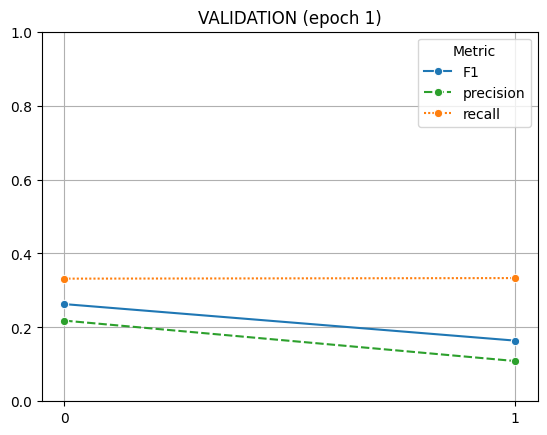

Epoch 1: 100%|██████████| 333/333 [00:25<00:00, 13.14it/s, v_num=6, val_loss=1.100, val_precision=0.109, val_recall=0.333, val_f1=0.164, train_loss=1.140, train_precision=0.335, train_recall=0.337, train_f1=0.305]

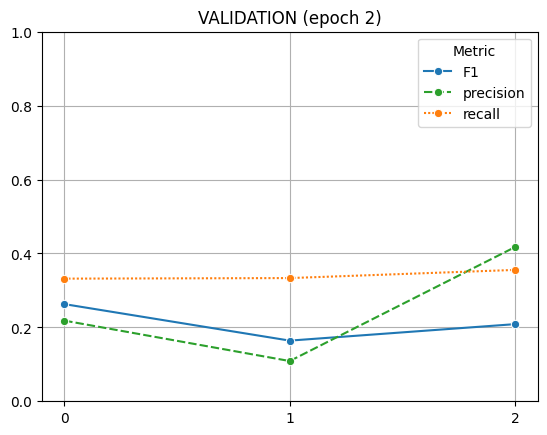

Epoch 2: 100%|██████████| 333/333 [00:25<00:00, 13.14it/s, v_num=6, val_loss=1.090, val_precision=0.417, val_recall=0.355, val_f1=0.209, train_loss=1.080, train_precision=0.368, train_recall=0.378, train_f1=0.339]

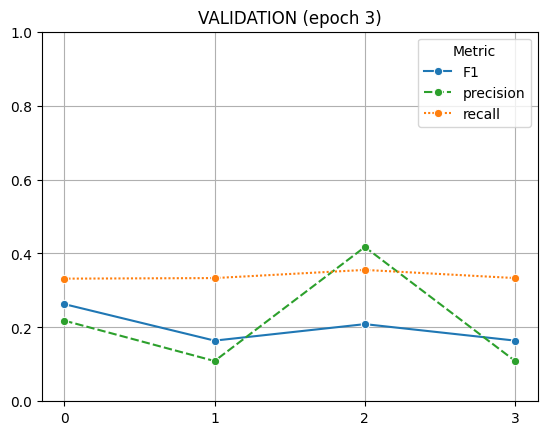

Epoch 3: 100%|██████████| 333/333 [00:25<00:00, 13.12it/s, v_num=6, val_loss=1.100, val_precision=0.109, val_recall=0.333, val_f1=0.164, train_loss=1.090, train_precision=0.247, train_recall=0.349, train_f1=0.287]

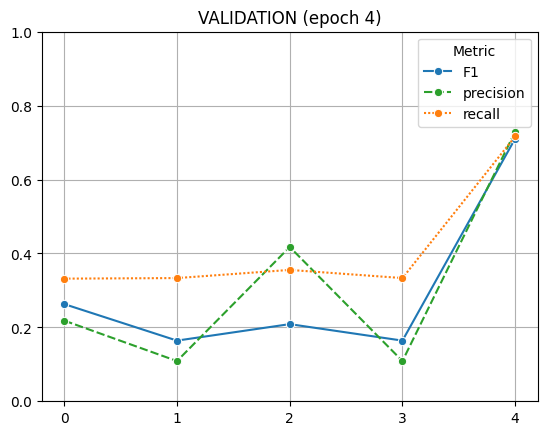

Epoch 4: 100%|██████████| 333/333 [00:25<00:00, 13.05it/s, v_num=6, val_loss=0.823, val_precision=0.730, val_recall=0.717, val_f1=0.711, train_loss=1.000, train_precision=0.482, train_recall=0.466, train_f1=0.420]

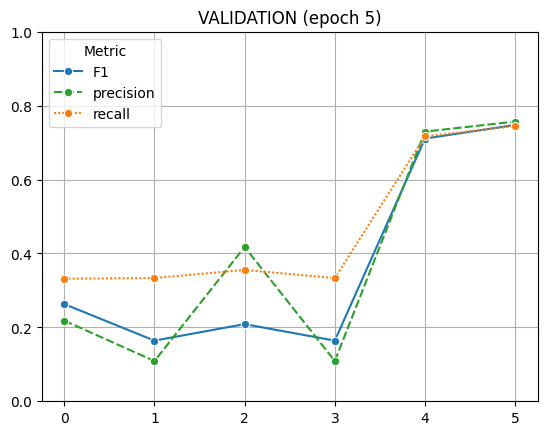

Epoch 4: 100%|██████████| 333/333 [00:26<00:00, 12.62it/s, v_num=6, val_loss=0.804, val_precision=0.757, val_recall=0.745, val_f1=0.748, train_loss=0.911, train_precision=0.667, train_recall=0.610, train_f1=0.574]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 333/333 [00:33<00:00, 10.00it/s, v_num=6, val_loss=0.804, val_precision=0.757, val_recall=0.745, val_f1=0.748, train_loss=0.911, train_precision=0.667, train_recall=0.610, train_f1=0.574]



In [20]:
trainer = Trainer(max_epochs = num_epochs)
trainer.fit(model, datamodule=dataloaders)

# Compute metrics on the test set

In [21]:
test_metrics = trainer.test(model = model, datamodule=dataloaders)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/bronzini/repositories/FM_2025/.venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.



INPUTS: 13316 --> TRAIN: 80.0 % || VALIDATION: 10.0 % || TEST: 10.0 % 

Testing DataLoader 0: 100%|██████████| 42/42 [00:00<00:00, 56.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_f1            0.7727944850921631
     test_precision          0.779716432094574
       test_recall           0.770110011100769
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Testing DataLoader 0: 100%|██████████| 42/42 [00:00<00:00, 56.51it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
──────────────────────────────────────────────────────────────────────────